In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 5.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 26.4 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.3.3
    Uninstalling safetensors-0.3.3:
      Successfully uninstalled safetensors-0.3.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.16.4
    Uninstalling huggingface-hub-0.16.4:
      Successfully uninstalled huggingface-hub-0.16.4
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [2]:
import json
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# Load the data from the JSON files
with open('/kaggle/input/indoml-2023-data/massive_train.data', 'r') as data_file:
    data = [json.loads(line) for line in data_file]

with open('/kaggle/input/indoml-2023-data/massive_train.solution', 'r') as solution_file:
    solutions = [json.loads(line) for line in solution_file]
    
class_names = []

with open('/kaggle/input/indoml-2023-labels/massive_labels.name', 'r') as file:
    for line in file:
        word = line.strip()  # Remove trailing newline and any leading/trailing whitespace
        class_names.append(word)
class_names[0]
    

'alarm_query'

In [10]:
print(data[0])

{'indoml_id': 'af-ZA|1', 'id': '1', 'locale': 'af-ZA', 'partition': 'train', 'scenario': 'alarm', 'utt': 'maak my wakker nege-uur v. m. op vrydag', 'annot_utt': 'maak my wakker [time : nege-uur v. m.] op [date : vrydag]', 'worker_id': '20', 'slot_method': [{'slot': 'time', 'method': 'translation'}, {'slot': 'date', 'method': 'translation'}], 'judgments': [{'worker_id': '40', 'intent_score': 1, 'slots_score': 1, 'grammar_score': 4, 'spelling_score': 2, 'language_identification': 'target'}, {'worker_id': '49', 'intent_score': 1, 'slots_score': 1, 'grammar_score': 4, 'spelling_score': 2, 'language_identification': 'target'}, {'worker_id': '20', 'intent_score': 1, 'slots_score': 1, 'grammar_score': 4, 'spelling_score': 2, 'language_identification': 'target'}]}


In [11]:
print(solutions[0])

{'indoml_id': 'af-ZA|1', 'intent': 'alarm_set'}


In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Function to filter and extract important words
def extract_important_words(phrase):
    phrase = phrase.replace("?","")
    phrase = phrase.replace(".","")
    stop_words = set(stopwords.words('english'))
    words = phrase.split()
    important_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(important_words)

In [13]:
# Create a dictionary to map indoml_id to intents
intent_map = {item['indoml_id']: item['intent'] for item in solutions}

# Split data into train and test sets (2:1) stratified by intent
indoml_ids = [item['indoml_id'] for item in data]
intents = [intent_map[indoml_id] for indoml_id in indoml_ids]

utt = [extract_important_words(item['utt']) for item in data]

num_classes = len(set(intents))
print("Number of classes")
print(num_classes)

train_data, test_data, train_labels, test_labels = train_test_split(
    utt, intents, test_size=0.1, random_state=42, stratify=intents
)

# unique_intents = []
# train_data = []
# train_labels =[]
# test_data = []
# test_labels = []

# for item in data:
#     intent = intent_map[item["indoml_id"]]
    
#     if intent not in unique_intents:
#         test_data.append(item["utt"])
#         test_labels.append(intent)
#         print(f'phrase: {item["utt"]}, intent: {intent}\n')
#         unique_intents.append(intent)
#     else:
#         train_data.append(item["utt"])
#         train_labels.append(intent)
        
# print(len(train_data))
# print(len(test_data))

Number of classes
60


In [9]:
# Load the tokenizer and model
model_name = "cartesinus/bert-base-uncased-amazon-massive-intent"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [10]:
# Tokenize the input data
train_encodings = tokenizer(
    train_data,
    truncation=True,
    padding=True,
    max_length=32,
    return_tensors='pt'    #return type is pytorch tensor
)

test_encodings = tokenizer(
    test_data,
    truncation=True,
    padding=True,
    max_length=32,
    return_tensors='pt'
)

In [29]:
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

train_labels[0]

3

In [12]:
# Create PyTorch datasets
class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IntentDataset(train_encodings, train_labels)
test_dataset = IntentDataset(test_encodings, test_labels)

In [14]:
model = BertForSequenceClassification.from_pretrained(model_name,num_labels=num_classes, ignore_mismatched_sizes=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cartesinus/bert-base-uncased-amazon-massive-intent and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([60]) in the checkpoint and torch.Size([150]) in the model instantiated
- classifier.weight: found shape torch.Size([60, 768]) in the checkpoint and torch.Size([150, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score


# Training arguments
training_args = TrainingArguments(
    output_dir='./intent_classification',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",  # use 'epoch' for evaluating every epoch
    logging_steps=20,
    eval_steps=20,
    save_total_limit=5,
    learning_rate=1.9*1e-5,
    num_train_epochs=1,
    # Specify optimizer parameters here
    adam_epsilon=1e-8,  # Example: Adam optimizer epsilon
    weight_decay=0.01,  # Example: Weight decay (L2 regularization)
    logging_dir='./logs',
)

# Create a trainer and train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
20,5.020300,4.961101
40,4.970000,4.850262
60,4.883600,4.762234
80,4.781100,4.704050
100,4.779800,4.662018
120,4.730800,4.644938


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 0, Eval Accuracy: 0.13777777777777778


Step,Training Loss,Validation Loss
20,4.566300,4.548798
40,4.517600,4.472361
60,4.497000,4.403563
80,4.420100,4.354438
100,4.418100,4.316981
120,4.354500,4.300193


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 1, Eval Accuracy: 0.28


Step,Training Loss,Validation Loss
20,4.258800,4.216185
40,4.160800,4.143716
60,4.111400,4.084920
80,4.105000,4.039001
100,4.065900,4.003608
120,4.076600,3.989357


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 2, Eval Accuracy: 0.4311111111111111


Step,Training Loss,Validation Loss
20,3.927900,3.915659
40,3.874500,3.857480
60,3.807300,3.801430
80,3.811100,3.756773
100,3.744300,3.729337
120,3.710100,3.711438


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 3, Eval Accuracy: 0.49333333333333335


Step,Training Loss,Validation Loss
20,3.634500,3.642891
40,3.571000,3.583091
60,3.455000,3.523316
80,3.546300,3.486227
100,3.465000,3.459937
120,3.470800,3.443621


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 4, Eval Accuracy: 0.5866666666666667


Step,Training Loss,Validation Loss
20,3.377700,3.396326
40,3.293600,3.335532
60,3.262100,3.284629
80,3.226300,3.244753
100,3.215700,3.214420
120,3.215700,3.198930


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 5, Eval Accuracy: 0.6088888888888889


Step,Training Loss,Validation Loss
20,3.058100,3.149263
40,3.056000,3.092804
60,3.045300,3.039716
80,2.971300,2.997846
100,2.970300,2.969057
120,2.927800,2.956650


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 6, Eval Accuracy: 0.6977777777777778


Step,Training Loss,Validation Loss
20,2.819100,2.902996
40,2.786400,2.860838
60,2.729300,2.810030
80,2.743400,2.767296
100,2.698000,2.739449
120,2.678700,2.727347


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 7, Eval Accuracy: 0.7422222222222222


Step,Training Loss,Validation Loss
20,2.589400,2.681780
40,2.589100,2.644178
60,2.509000,2.592229
80,2.518300,2.562297
100,2.426900,2.529301
120,2.459400,2.514441


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 8, Eval Accuracy: 0.7644444444444445


Step,Training Loss,Validation Loss
20,2.358900,2.467312
40,2.307600,2.422001
60,2.289100,2.373655
80,2.286600,2.334673
100,2.191900,2.309104
120,2.239400,2.298869


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 9, Eval Accuracy: 0.8


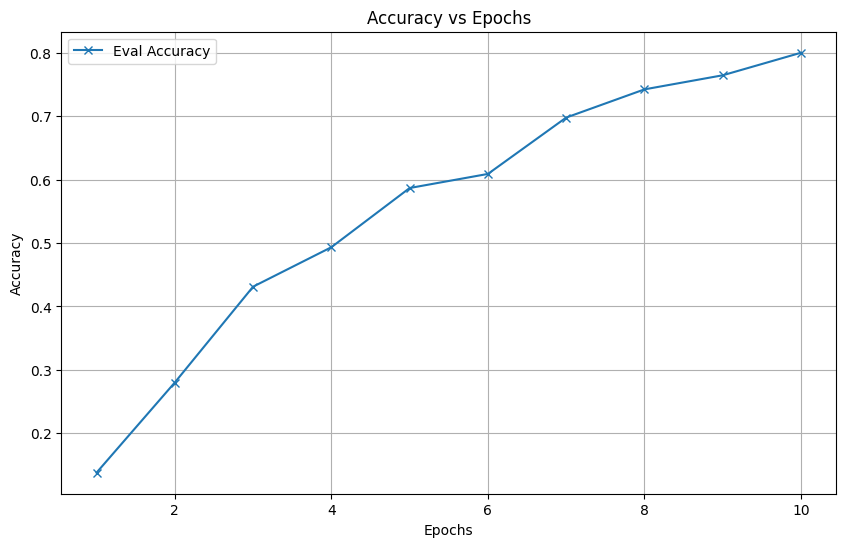

In [16]:
# Initialize empty lists to store accuracy and step values
num_epochs=10
eval_acc_values = []

# Training loop with logging accuracy
for epoch in range(num_epochs):
    trainer.train()
    
    # Predict on the test set
    raw_predictions = trainer.predict(test_dataset)
    predicted_labels = np.argmax(raw_predictions.predictions, axis=1)
    
    report = classification_report(test_labels, predicted_labels, target_names=list(label_map.keys()), output_dict=True)

    accuracy = report['accuracy']
    eval_acc_values.append(accuracy)
    
    print(f"epoch: {epoch}, Eval Accuracy: {accuracy}")
    

# Plot accuracy vs steps
plt.figure(figsize=(10, 6))
plt.plot([i+1 for i in range(num_epochs)], eval_acc_values, label="Eval Accuracy", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

Step,Training Loss,Validation Loss
20,1.185600,1.425528
40,1.205000,1.398164
60,1.147400,1.357306
80,1.081600,1.331035
100,1.099500,1.308987
120,1.103400,1.299015


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 0, Eval Accuracy: 0.9022222222222223


Step,Training Loss,Validation Loss
20,1.037100,1.294388
40,1.002600,1.266062
60,0.990100,1.247544
80,0.977400,1.209318
100,0.967800,1.202799
120,0.944000,1.190594


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 1, Eval Accuracy: 0.8844444444444445


Step,Training Loss,Validation Loss
20,0.874400,1.181558
40,0.848300,1.138095
60,0.888600,1.122002
80,0.836600,1.094659
100,0.851200,1.076149
120,0.826900,1.067335


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch: 2, Eval Accuracy: 0.8933333333333333


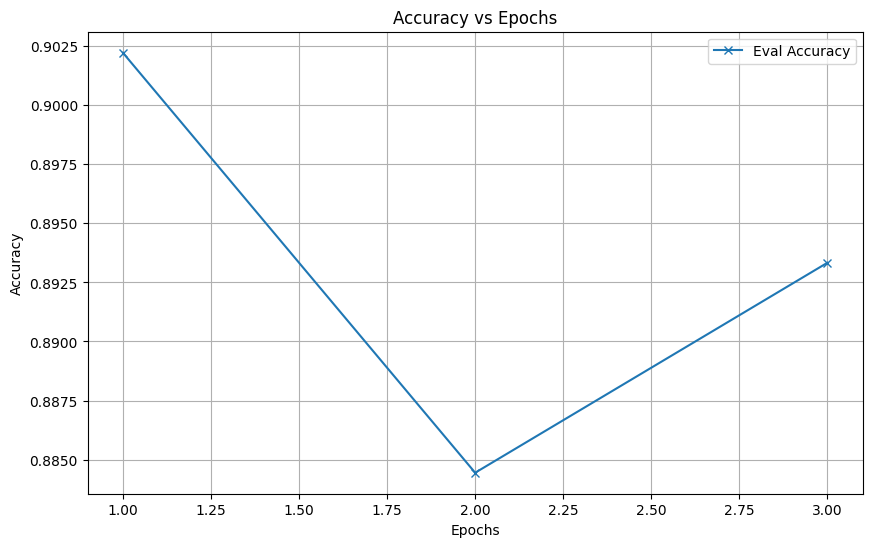

In [19]:
# Initialize empty lists to store accuracy and step values
num_epochs=3
eval_acc_values = []

# Training loop with logging accuracy
for epoch in range(num_epochs):
    trainer.train()
    
    # Predict on the test set
    raw_predictions = trainer.predict(test_dataset)
    predicted_labels = np.argmax(raw_predictions.predictions, axis=1)
    
    report = classification_report(test_labels, predicted_labels, target_names=list(label_map.keys()), output_dict=True)

    accuracy = report['accuracy']
    eval_acc_values.append(accuracy)
    
    print(f"epoch: {epoch}, Eval Accuracy: {accuracy}")
    

# Plot accuracy vs steps
plt.figure(figsize=(10, 6))
plt.plot([i+1 for i in range(num_epochs)], eval_acc_values, label="Eval Accuracy", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Predict on the test set
raw_predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(raw_predictions.predictions, axis=1)

# Convert labels back to original intents
predicted_intents = [list(label_map.keys())[list(label_map.values()).index(label)] for label in predicted_labels]

# Print one sample prediction
sample_idx = random.randint(0, len(test_data) - 1)
sample_text = test_data[sample_idx]
sample_intent = predicted_intents[sample_idx]

print(f"Sample Text: {sample_text}")
print(f"Predicted Intent: {sample_intent}")

Sample Text: give example existentialism practice
Predicted Intent: definition


In [21]:
# Calculate accuracy, precision, recall, and F1-score
report = classification_report(test_labels, predicted_labels, target_names=list(label_map.keys()), output_dict=True)

accuracy = report['accuracy']
precision = report['macro avg']['precision']
recall = report['macro avg']['recall']
f1_score = report['macro avg']['f1-score']

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.8933
Precision: 0.8816
Recall: 0.9000
F1 Score: 0.8751


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
# Load the data from the JSON files
with open('/kaggle/input/test-data/massive_test.data', 'r') as data_file:
    final_test_data = [json.loads(line) for line in data_file]
    
    
test_utt=[]
for item in final_test_data:
    test_utt.append(item["utt"])

In [169]:
json_file_name = "test.utt"

# Open the file in write mode and write each dictionary as a JSON object on a new line
with open(json_file_name, "w") as json_file:
    for stmt in test_utt:
        json.dump(stmt, json_file)
        json_file.write('\n')

In [162]:
final_test_data[0]

{'indoml_id': 1,
 'utt': 'Kindly show me my entire transaction record from the beginning of this year.'}

In [163]:
# Tokenize the input data
final_test_encodings = tokenizer(
    [item['utt'] for item in final_test_data],
    truncation=True,
    padding=True,
    max_length=32,
    return_tensors='pt'  # Return type is a PyTorch tensor
)

In [164]:
# Create a custom dataset for the final test data
class FinalTestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])

final_test_dataset = FinalTestDataset(final_test_encodings)

In [165]:
# Predict on the test set
final_raw_predictions = trainer.predict(final_test_dataset)
final_predicted_labels = np.argmax(final_raw_predictions.predictions, axis=1)

# Convert labels back to original intents
final_predicted_intents = [list(label_map.keys())[list(label_map.values()).index(label)] for label in final_predicted_labels]

# Create a dictionary list with "indoml_id" and "intent" keys
intent_dict_list = [{"indoml_id": data["indoml_id"], "intent": intent} for data, intent in zip(final_test_data, final_predicted_intents)]

json_file_name = "massive_test_TeamIITKgp_sub6.predict"
# Open the file in write mode and write each dictionary on a new line
with open(json_file_name, "w") as json_file:
    for intent_dict in intent_dict_list:
        json_file.write('{"indoml_id": ' + str(intent_dict["indoml_id"]) + ', "intent": "' + intent_dict["intent"] + '"}\n')

# Optionally, print the created dictionary list
print(intent_dict_list[0:10])

[{'indoml_id': 1, 'intent': 'transactions'}, {'indoml_id': 2, 'intent': 'order'}, {'indoml_id': 3, 'intent': 'sync device'}, {'indoml_id': 4, 'intent': 'interest rate'}, {'indoml_id': 5, 'intent': 'calendar update'}, {'indoml_id': 6, 'intent': 'jump start'}, {'indoml_id': 7, 'intent': 'credit score'}, {'indoml_id': 8, 'intent': 'next song'}, {'indoml_id': 9, 'intent': 'credit limit change'}, {'indoml_id': 10, 'intent': 'expiration date'}]


In [1]:
import os
import shutil

def clear_directory(directory_path):
    # Check if the directory exists
    if os.path.exists(directory_path):
        # Iterate over the files and subdirectories in the directory
        for item in os.listdir(directory_path):
            item_path = os.path.join(directory_path, item)
            
            # If it's a file, remove it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, remove it recursively
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)

        print(f"Contents of '{directory_path}' have been cleared.")
    else:
        print(f"Directory '{directory_path}' does not exist.")

In [ ]:
import json

# Example list of predicted intents
predicted_intents = ["intent1", "intent2", "intent3", "intent4"]


# Example test_data table (replace with your actual data)
test_data = [
    {"indoml_id": 1, "utt": "text1"},
    {"indoml_id": 2, "utt": "text2"},
    {"indoml_id": 3, "utt": "text3"},
    {"indoml_id": 4, "utt": "text4"},
]

# Create a dictionary list with "indoml_id" and "intent" keys
intent_dict_list = [{"indoml_id": data["indoml_id"], "intent": intent} for data, intent in zip(test_data, predicted_intents)]

# Save the dictionary list as a JSON file with the desired name
json_file_name = "massive_test_TeamIITKgp.predict"
with open(json_file_name, "w") as json_file:
    json.dump(intent_dict_list, json_file)

# Optionally, print the created dictionary list
print(intent_dict_list)


In [2]:
# Specify the directory you want to clear
directory_to_clear = '/kaggle/working/'

# Call the function to clear the directory
clear_directory(directory_to_clear)

Contents of '/kaggle/working/' have been cleared.
